In [36]:
import pymongo
import mysql.connector
from pymongo import MongoClient
import csv
import os
import pandas as pd
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt

class StaticProductData:
    
    def __init__(self):
        # Lấy thông tin kết nối từ biến môi trường
        self.user = 'root'
        self.password = os.getenv('DB_PASSWORD')
        self.host = 'localhost'
        self.database = 'tiki'
        self.table_name = 'tiki_product_data'
        self.mongodb_name = 'ecommerce'
        self.csv_file =  './data/static_categories.csv'
        self.csv_origins = './data/origins.csv'
        self.csv_product_ingredients = './data/product_ingredients.csv'
        
        self.client = MongoClient('localhost', 27017)
        self.db = self.client[self.mongodb_name]
        self.collection = self.db['products']
        
        # Kiểm tra xem các biến môi trường đã được thiết 
        if not all([self.user, self.password, self.host, self.database]):
            raise ValueError("Các biến môi trường không được thiết lập đầy đủ.")
            
    def static_category(self):
         # Kiểm tra xem file tồn tại hay không
        if not os.path.exists(self.csv_file):
            # Thực hiện truy vấn để thống kê số lượng sản phẩm cho mỗi danh mục
            pipeline = [
                {
                    '$group': {
                        '_id': '$categories.name',
                        'count': {'$sum': 1}
                    }
                }
            ]

            result = self.collection.aggregate(pipeline)
            # Dữ liệu danh mục và số lượng sản phẩm
            categories = []
            product_counts = []
            # In kết quả
            for category in result:
                category_name = category['_id']
                product_count = category['count']
                if category_name is not None and product_count is not None:  # Kiểm tra giá trị trước khi thêm vào danh sách
                    categories.append(category_name)
                    product_counts.append(product_count)

            self.StoreCategoriesDataToCSV(categories, product_counts)
        df = pd.read_csv(self.csv_file)
        self.showBarChartOfCategories(df)
        
    def StoreCategoriesDataToCSV(self, categories, product_counts):
        # Mở file CSV và ghi dữ liệu
        with open(self.csv_file, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Category', 'Product'])  # Ghi tiêu đề cột
            for category, count in zip(categories, product_counts):
                writer.writerow([category, count])  # Ghi dữ liệu từng dòng
                
    def showBarChartOfCategories(self, df):
        df_sorted = df.sort_values(by='Product', ascending=False)
        df_sorted = df_sorted.reset_index(drop=True)
        print(f"Thống kê danh sách danh mục theo sản phẩm \n{df_sorted}\n\n")
        df_subset = df_sorted[:10]

        # Tạo biểu đồ cột ngang
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)  # Đặt kích thước theo ý muốn

        # Đặt các đỉnh của cột ngang
        ax.barh(range(len(df_subset)), df_subset['Product'], color='steelblue')
        ax.set_yticks(range(len(df_subset)))
        ax.set_yticklabels(df_subset['Category'])

        # Đặt tiêu đề và nhãn cho trục x
        ax.set_xlabel('Số lượng sản phẩm')
        ax.set_ylabel('Danh mục')
        ax.set_title('Top 10 danh mục có số lượng sản phẩm nhiều nhất')

        # Tạo chú thích
        for i, category in enumerate(df_subset['Category']):
            ax.text(df_subset['Product'][i], i, str(df_subset['Product'][i]), va='center')

        # Hiển thị biểu đồ
        plt.tight_layout()
        plt.show()
                
    def StaticsOriginsData(self):
        
        # Kiểm tra xem file tồn tại hay không
        if not os.path.exists(self.csv_origins):
            pipeline = [
                {
                    '$unwind': '$specifications'
                },
                {
                    '$unwind': '$specifications.attributes'
                },
                {
                    '$match': {
                        'specifications.attributes.code': 'origin'
                    }
                },
                {
                    '$group': {
                        '_id': '$specifications.attributes.value',
                        'count': {'$sum': 1}
                    }
                },
                {
                    '$match': {
                        '_id': {'$ne': None}
                    }
                }
            ]

            result = self.collection.aggregate(pipeline)
            # Tạo danh sách xuất xứ và số lượng tương ứng
            origins = []
            counts = []
            for item in result:
                origin = item['_id']
                count = item['count']
                if origin is not None and count is not None:  # Kiểm tra giá trị trước khi thêm vào danh sách
                    origins.append(origin)
                    counts.append(count)
                self.StoreCountriesDataToCSV(origins, counts)
        df = pd.read_csv(self.csv_origins)
        print(df.sort_values(by='Counts', ascending=False).reset_index(drop=True))
        
    def StoreCountriesDataToCSV(self, origins, counts):
        # Mở file CSV và ghi dữ liệu
        with open(self.csv_origins, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Origins', 'Counts'])  # Ghi tiêu đề cột
            for origin, count in zip(origins, counts):
                writer.writerow([origin, count])  # Ghi dữ liệu từng dòng

    def createProductIngredientsFile(self):
         # Kiểm tra xem file tồn tại hay không
        if not os.path.exists(self.csv_product_ingredients):
             # Kiểm tra kết nối tới MySQL
            try:
                self.mysql_cnx = mysql.connector.connect(user=self.user, password=self.password,
                                                         host=self.host, db=self.database)
                self.mysql_cursor = self.mysql_cnx.cursor()

                # Truy vấn các sản phẩm có thông tin "thành phần" trong mô tả
                query = f"""
                    SELECT product_name, description
                    FROM {self.table_name}
                    WHERE description LIKE '%thành phần%'
                """
                # Use all the SQL you like
                self.mysql_cursor.execute(query)

                # Tạo danh sách dữ liệu
                data = []
                for product_name, description in self.mysql_cursor.fetchall():
                    # Trích xuất thông tin thành phần từ miêu tả
                    ingredients = ""
                    if description:
                        description = description.replace("\n", "")
                        start_index = description.lower().find("thành phần")
                        if start_index != -1:
                            start_index += len("thành phần")
                            end_index = description.find("\n", start_index)
                            ingredients = description[start_index:end_index].strip()
                    data.append({"product_name": product_name, "ingredient": ingredients})

                # Lưu dữ liệu vào file CSV
                fieldnames = ["product_name", "ingredient"]

                with open(self.csv_product_ingredients, mode="w", newline="", encoding="utf-8") as file:
                    writer = csv.DictWriter(file, fieldnames=fieldnames)
                    writer.writeheader()
                    writer.writerows(data)
                print("File has been created")    
                # Đóng con trỏ và kết nối
                self.mysql_cursor.close()
            except mysql.connector.Error:
                raise ValueError("Không thể kết nối tới MySQL.")
        df = pd.read_csv(self.csv_product_ingredients)
        print(df[['product_name', 'ingredient']])
    
static = StaticProductData()

Thống kê danh sách danh mục theo sản phẩm 
                      Category  Product
0                         Root   543435
1                   Thời Trang    31595
2            Đồ Chơi - Mẹ & Bé    18274
3           Nhà Cửa - Đời Sống    17705
4              Sách tiếng Việt    15468
...                        ...      ...
2725                   Áo ngực        1
2726           Rồng phong thủy        1
2727     Sơn, dầu mỡ, hóa chất        1
2728          Freeship từ 250K        1
2729  Bảo hiểm rơi vỡ màn hình        1

[2730 rows x 2 columns]




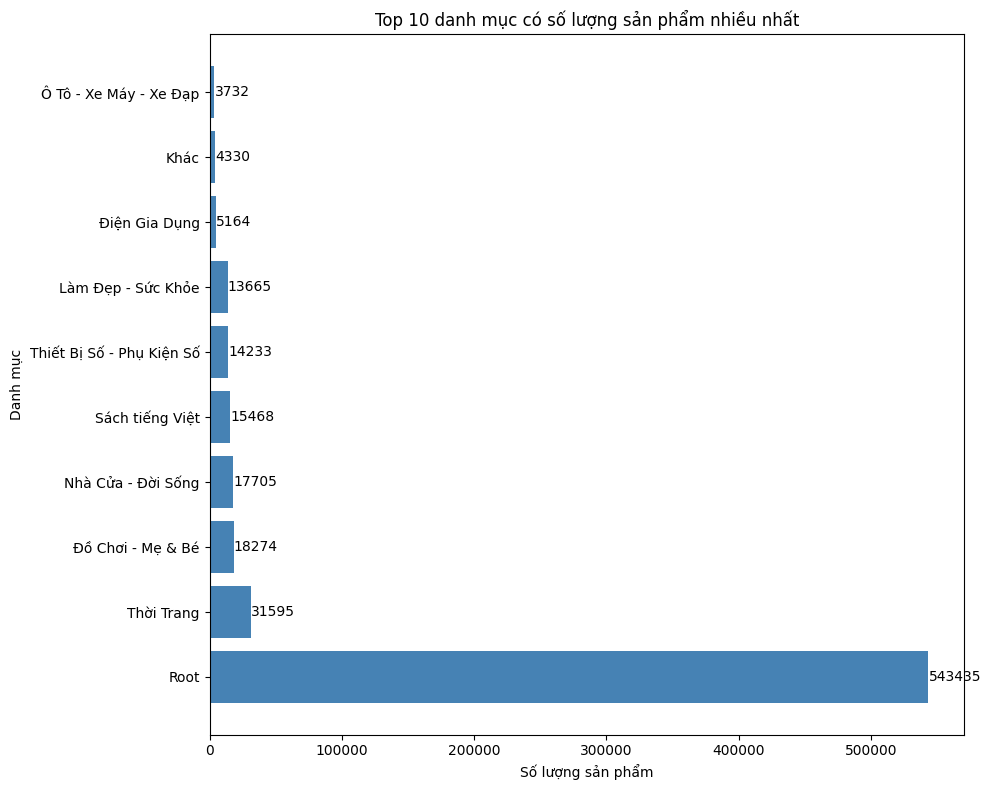

In [24]:
static.static_category()

In [27]:
static.StaticsOriginsData()

              Origins  Counts
0            Việt Nam  728872
1          Trung Quốc  184497
2               China  110990
3               china   53273
4            Hàn Quốc   22083
..                ...     ...
187           Georgia       1
188      El Salvandor       1
189  Brazil - Uruquay       1
190             Ghana       1
191  Malaysia/ Mexico       1

[192 rows x 2 columns]


In [37]:
static.createProductIngredientsFile()

                                             product_name   
0          Hộp Cơm Điện Hâm Nóng Đa Năng Magic A-03 1.05L  \
1                Bộ Chén Ăn Có Đế Dính - Thìa KuKu KU5395   
2                    Kem Chăm Sóc Giày GoldCare - GC 1004   
3       Bộ Chăm Sóc Giày GoldCare (Bàn Chải + Tuýp Kem...   
4                Bút Chì Kim Kĩ Thuật Pentel A125T 0.5mm    
...                                                   ...   
110521                  Mực Ghim Sài Thành ĐL 500g (Khay)   
110522  Pizza Bánh Mì Bistro Cà Chua Và Phô Mai Dr. Oe...   
110523  Pizza Bánh Mì Bistro Nấm Champignon Dr. Oetker...   
110524  Pizza Bánh Mì Bistro 4 Phô Mai Dr. Oetker 125g...   
110525                                Cơm Mẻ Elkei (500g)   

                                               ingredient  
0       độc hại cho sức khoẻ người dùng.Hộp cơm được t...  
1       :+   Nắp, thân chén, muỗng: nhựa PP+   Đế: TPR...  
2       từ sáp tự nhiên tạo nên một hỗn hợp dạng kem g...  
3       từ sáp tự nhiên, bổ